In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 1 – Create tickers.txt
# ──────────────────────────────────────────────────────────────
tickers = ["MSFT", "GOOGL", "TSLA", "META", "NFLX"]
with open("tickers.txt", "w") as f:
    for t in tickers:
        f.write(t + "\n")
print("tickers.txt created with", len(tickers), "tickers")

tickers.txt created with 5 tickers


In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 2 – Imports (modified: added math)
# ──────────────────────────────────────────────────────────────
import os, random, math
from collections import deque, namedtuple
import numpy as np, pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
from tqdm import trange, tqdm
import matplotlib.pyplot as plt   # <-- NEW: for plotting

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 3 – Config (tuned for higher returns)
# ──────────────────────────────────────────────────────────────
DATA_DIR = 'data'
TICKERS_FILE = 'tickers.txt'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
WINDOW_SIZE = 30          # ↑ Increased from 20 → richer context
MAX_SHARES = 100         # ↑ Allow more position sizing
EMB_SIZE = 32            # ↑ Better ticker embedding
GAMMA = 0.99
LR = 3e-4                # ↑ Slightly higher LR for faster convergence
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRANS_FEE = 0.001        # 0.1% realistic fee

# PPO hyper-parameters (aggressive exploration + stability)
CLIP_EPS = 0.15          # ↓ Tighter clip → less policy oscillation
VALUE_COEF = 0.5
ENT_COEF = 0.05          # ↑ Stronger exploration across stocks
GAE_LAM = 0.95
EPOCHS = 6               # ↑ More update epochs per rollout
MINIBATCH_SIZE = 128     # ↑ Larger batches for stable gradients
ROLLOUT_SIZE = 8192      # ↑ More data per update
HORIZON = 256            # ↑ Longer episode fragments
TRAIN_STEPS = 1_200_000  # ↑ 2× more training steps

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 4 – Utility
# ──────────────────────────────────────────────────────────────
def ensure_dir(d):
    os.makedirs(d, exist_ok=True)

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 5 – MarketData (unchanged)
# ──────────────────────────────────────────────────────────────
class MarketData:
    def __init__(self, tickers_file=TICKERS_FILE, data_dir=DATA_DIR,
                 start=START_DATE, end=END_DATE):
        self.tickers_file = tickers_file
        self.data_dir = data_dir
        self.start = start
        self.end = end
        ensure_dir(self.data_dir)
        self.tickers = self._read_tickers()
        self.scalers = {}
    def _read_tickers(self):
        with open(self.tickers_file) as f:
            return [t.strip().upper() for t in f if t.strip()]
    def get_train_test_split(self, ticker, train_end='2022-12-31'):
        df = self.load_df(ticker)
        train_df = df[df.index <= train_end].copy()
        test_df = df[df.index > train_end].copy()
        return train_df, test_df
    def download_all(self):
        for t in tqdm(self.tickers, desc='Downloading'):
            path = os.path.join(self.data_dir, f'{t}.csv')
            if os.path.exists(path): continue
            df = yf.download(t, start=self.start, end=self.end, progress=False)
            if df.empty: continue
            df.to_csv(path)
    def load_df(self, ticker):
        path = os.path.join(self.data_dir, f'{ticker}.csv')
        df = pd.read_csv(path, index_col=0, parse_dates=True).dropna()
        return df
    def compute_features(self, df):
        df = df.copy()
        for c in ['Open','High','Low','Close','Adj Close','Volume']:
            if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')
        df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill')
        df['ret'] = df['Close'].pct_change().fillna(0)
        df['log_ret'] = np.log(df['Close']).diff().fillna(0)
        df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
        df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
        df['ema10'] = df['Close'].ewm(span=10, adjust=False).mean()
        df['std5'] = df['Close'].rolling(5).std().fillna(0)
        delta = df['Close'].diff()
        up, down = delta.clip(lower=0), -delta.clip(upper=0)
        rs = up.rolling(14).mean() / (down.rolling(14).mean() + 1e-6)
        df['rsi'] = 100 - 100/(1+rs)
        df['bb_upper'] = df['ma10'] + 2*df['std5']
        df['bb_lower'] = df['ma10'] - 2*df['std5']
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['macd'] = ema12 - ema26
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        df['mom'] = df['Close'] - df['Close'].shift(10)
        df['vol'] = df['Volume']
        cols = ['Close','Open','High','Low','ret','log_ret','ma5','ma10','ema10',
                'std5','vol','rsi','bb_upper','bb_lower','macd','macd_signal','mom']
        return df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    def fit_scaler(self):
        for t in tqdm(self.tickers, desc='Fitting scalers'):
            try: df = self.load_df(t)
            except FileNotFoundError: continue
            feat = self.compute_features(df)
            self.scalers[t] = StandardScaler().fit(feat.values)

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 6 – TradingEnv (Sharpe-reward + cash/shares in state)
# ──────────────────────────────────────────────────────────────
class TradingEnv:
    def __init__(self, features_df, scaler, ticker_idx,
                 window_size=WINDOW_SIZE, initial_cash=10000):
        self.df = features_df.reset_index(drop=True)
        self.scaler = scaler
        self.window = window_size
        self.ticker_idx = ticker_idx
        self.initial_cash = initial_cash
        self.reset_episode()

    def reset_episode(self, start_idx=None):
        max_start = len(self.df) - self.window - 2
        if max_start <= 0: raise ValueError('Data too short')
        self.pos = start_idx if start_idx is not None else random.randint(0, max_start)
        self.current_step = self.pos + self.window
        self.end_step = len(self.df) - 1
        self.cash = self.initial_cash
        self.shares = 0
        self.history = []                     # (value, ret) for Sharpe
        self.done = False
        return self._get_state()

    def _get_state(self):
        sl = self.df.iloc[self.current_step-self.window:self.current_step]
        X = self.scaler.transform(sl.values).flatten()
        cash_norm   = self.cash / self.initial_cash
        shares_norm = self.shares / MAX_SHARES
        state = np.concatenate([X, [cash_norm, shares_norm]])
        return {'obs': state.astype(np.float32), 'ticker_idx': self.ticker_idx}

    def step(self, action):
        price = float(self.df.iloc[self.current_step]['Close'])
        prev_val = self.cash + self.shares * price
        self.history.append((prev_val, 0.0))

        # ---- aggressive position scaling ----
        if action == 1:                     # BUY
            cost = price * (1 + TRANS_FEE)
            can_buy = min(MAX_SHARES - self.shares,
                          int(self.cash // cost))
            if can_buy:
                self.shares += can_buy
                self.cash   -= can_buy * cost
        elif action == 2 and self.shares:   # SELL
            can_sell = min(self.shares, 5)   # sell up to 5 shares
            revenue = can_sell * price * (1 - TRANS_FEE)
            self.shares -= can_sell
            self.cash   += revenue

        self.current_step += 1
        if self.current_step > self.end_step:
            self.done = True
            self.current_step = self.end_step

        new_price = float(self.df.iloc[self.current_step]['Close'])
        new_val   = self.cash + self.shares * new_price

        # ---- Sharpe-like reward (log-return + activity) ----
        log_ret = math.log(new_val / prev_val) if prev_val > 0 else 0.0
        activity = 0.02 * abs(self.shares - (prev_val - self.cash) / price) / MAX_SHARES
        reward = log_ret + activity

        # store for Sharpe calculation in validation
        self.history[-1] = (new_val, log_ret)

        return self._get_state(), reward, self.done, {}

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 7 – Helper to stack states (updated for new state)
# ──────────────────────────────────────────────────────────────
def stack_states(states):
    obs = np.stack([s['obs'] for s in states])
    tidx = np.array([s['ticker_idx'] for s in states], dtype=np.int64)
    return obs, tidx

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 8 – Actor (Policy) network (wider + LayerNorm)
# ──────────────────────────────────────────────────────────────
class PolicyNet(nn.Module):
    def __init__(self, state_dim, n_tickers, emb_size=EMB_SIZE, n_actions=3):
        super().__init__()
        self.emb = nn.Embedding(n_tickers, emb_size)
        hidden = 512
        self.net = nn.Sequential(
            nn.Linear(state_dim + emb_size, hidden), nn.LayerNorm(hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.LayerNorm(hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.LayerNorm(hidden), nn.Tanh(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, obs, tidx):
        e = self.emb(tidx)
        x = torch.cat([obs, e], dim=1)
        return self.net(x)

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 9 – Critic (Value) network (deeper + Tanh)
# ──────────────────────────────────────────────────────────────
class ValueNet(nn.Module):
    def __init__(self, state_dim, n_tickers, emb_size=EMB_SIZE):
        super().__init__()
        self.emb = nn.Embedding(n_tickers, emb_size)
        hidden = 512  # ↑ Wider layers
        self.net = nn.Sequential(
            nn.Linear(state_dim + emb_size, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),  # ↑ Extra layer
            nn.Linear(hidden, 1)
        )
    def forward(self, obs, tidx):
        e = self.emb(tidx)
        x = torch.cat([obs, e], dim=1)
        return self.net(x)

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 10 – PPO training (SAFE: NO validate_ppo DURING training)
# ──────────────────────────────────────────────────────────────
def train_ppo():
    md = MarketData()
    print('Tickers:', len(md.tickers))
    md.download_all()
    md.fit_scaler()
    data_store, valid_tickers = [], []
    for i, t in enumerate(md.tickers):
        try:
            train_df, _ = md.get_train_test_split(t)
        except FileNotFoundError:
            continue
        feat = md.compute_features(train_df)
        if len(feat) < WINDOW_SIZE + 2: continue
        data_store.append((t, feat))
        valid_tickers.append(t)
    n_tickers = len(valid_tickers)
    print('Usable tickers:', n_tickers)
    scalers = {t: md.scalers[t] for t in valid_tickers}

    # state_dim = window_features + cash_norm + shares_norm
    sample = data_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample.size + 2

    policy = PolicyNet(state_dim, n_tickers).to(DEVICE)
    critic = ValueNet(state_dim, n_tickers).to(DEVICE)
    opt = optim.Adam(list(policy.parameters()) + list(critic.parameters()), lr=LR)

    steps = 0
    pbar = trange((TRAIN_STEPS // ROLLOUT_SIZE) + 1)

    for update in pbar:
        # ---- entropy decay ----
        ent_coef = ENT_COEF * max(0.1, 1.0 - update / ((TRAIN_STEPS // ROLLOUT_SIZE) * 0.7))

        # ---- rollout ----
        obs_l, tidx_l, act_l, logp_l = [], [], [], []
        rew_l, done_l, val_l = [], [], []
        collected = 0
        envs = []

        while collected < ROLLOUT_SIZE:
            tidx = random.randrange(n_tickers)
            t, feat = data_store[tidx]
            env = TradingEnv(feat, scalers[t], ticker_idx=tidx)
            s = env.reset_episode()
            envs.append(env)
            for _ in range(HORIZON):
                if env.done: break
                obs_t = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
                tidx_t = torch.tensor([s['ticker_idx']]).long().to(DEVICE)
                with torch.no_grad():
                    logits = policy(obs_t, tidx_t)
                    value = critic(obs_t, tidx_t)
                probs = torch.softmax(logits, dim=-1)
                a = torch.multinomial(probs, 1).item()
                logp = torch.log(probs[0, a])
                s2, r, d, _ = env.step(a)
                obs_l.append(s['obs']); tidx_l.append(s['ticker_idx'])
                act_l.append(a); logp_l.append(logp.item())
                rew_l.append(r); done_l.append(d); val_l.append(value.item())
                s = s2; collected += 1; steps += 1
                if steps >= TRAIN_STEPS: break
            if steps >= TRAIN_STEPS: break
        if steps >= TRAIN_STEPS: break

        # ---- last value ----
        last_vals = [0.0] * len(rew_l)
        for i, env in enumerate(envs[-len(rew_l):]):
            if not env.done:
                o = torch.from_numpy(env._get_state()['obs']).float().unsqueeze(0).to(DEVICE)
                ti = torch.tensor([env.ticker_idx]).long().to(DEVICE)
                last_vals[i] = critic(o, ti).item()
        next_vals = val_l[1:] + [last_vals[-1]]

        # ---- GAE ----
        advs = []
        gae = 0.0
        for t in reversed(range(len(rew_l))):
            delta = rew_l[t] + GAMMA * next_vals[t] * (1 - int(done_l[t])) - val_l[t]
            gae = delta + GAMMA * GAE_LAM * (1 - int(done_l[t])) * gae
            advs.insert(0, gae)
        returns = [a + v for a, v in zip(advs, val_l)]

        # ---- tensors ----
        obs_t  = torch.from_numpy(np.stack(obs_l)).float().to(DEVICE)
        tidx_t = torch.tensor(tidx_l).long().to(DEVICE)
        act_t  = torch.tensor(act_l).long().to(DEVICE)
        oldlogp= torch.tensor(logp_l).float().to(DEVICE)
        adv_t  = torch.tensor(advs).float().to(DEVICE)
        ret_t  = torch.tensor(returns).float().to(DEVICE)
        adv_t  = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

        # ---- PPO update ----
        for _ in range(EPOCHS):
            idx = torch.randperm(len(rew_l))
            for start in range(0, len(rew_l), MINIBATCH_SIZE):
                mb = idx[start:start+MINIBATCH_SIZE]
                o,ti,a,olp,ad,rt = (obs_t[mb], tidx_t[mb], act_t[mb],
                                    oldlogp[mb], adv_t[mb], ret_t[mb])
                logits = policy(o, ti)
                vals   = critic(o, ti).squeeze()
                logp   = torch.log_softmax(logits, -1).gather(1, a.unsqueeze(1)).squeeze()
                ratio  = torch.exp(logp - olp)
                s1 = ratio * ad
                s2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * ad
                pol_loss = -torch.min(s1, s2).mean()
                val_loss = nn.MSELoss()(vals, rt)
                entropy  = -(torch.softmax(logits, -1) * torch.log_softmax(logits, -1)).sum(-1).mean()
                loss = pol_loss + VALUE_COEF * val_loss - ent_coef * entropy
                opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(list(policy.parameters())+list(critic.parameters()), 0.5)
                opt.step()

        pbar.set_postfix({'steps': steps})

    # ---- SAVE ONLY AFTER TRAINING ----
    torch.save({
        'policy_state_dict': policy.state_dict(),
        'scalers': scalers,
        'tickers': valid_tickers,
        'val_log': []
    }, 'ppo_trading_multi_stock.pth')
    print('Training finished → ppo_trading_multi_stock.pth')

In [ ]:
train_ppo()

Tickers: 5


Fitting scalers:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1270889352.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','

Usable tickers: 5


 98%|█████████▊| 144/147 [34:50<00:43, 14.52s/it, steps=1.2e+6]

Training finished → ppo_trading_multi_stock.pth


In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 12 – Validation (with plots: validation return over training, vs eval)
# ──────────────────────────────────────────────────────────────
def validate_ppo(model_path='ppo_trading_multi_stock.pth', return_dict=False):
    safe = [StandardScaler, np.float64,np.float32,np.int64,np.int32,np.bool_,np.int8,np.int16]
    with torch.serialization.safe_globals(safe):
        ckpt = torch.load(model_path, map_location=DEVICE, weights_only=False)
    scalers = ckpt['scalers']
    tickers = ckpt['tickers']
    val_log = ckpt.get('val_log', [])  # (step, avg_ret) list
    md = MarketData()
    data_store = []
    for t in tickers:
        _, test_df = md.get_train_test_split(t)
        feat = md.compute_features(test_df)
        data_store.append((t, feat))
    sample = data_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample.size + 2  # +2 for cash_norm, shares_norm
    policy = PolicyNet(state_dim, len(tickers)).to(DEVICE)
    policy.load_state_dict(ckpt['policy_state_dict'])
    policy.eval()

    results = {}
    portfolio_hist = {}
    for i, (t, feat) in enumerate(data_store):
        env = TradingEnv(feat, scalers[t], ticker_idx=i)
        s = env.reset_episode(start_idx=0)  # fixed start
        portfolio_values = [env.initial_cash]
        while not env.done:
            obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
            ti = torch.tensor([s['ticker_idx']]).long().to(DEVICE)
            with torch.no_grad():
                a = policy(obs, ti).argmax(dim=1).item()
            s, _, done, _ = env.step(a)
            current_val = env.cash + env.shares * float(env.df.iloc[env.current_step]['Close'])
            portfolio_values.append(current_val)
        portfolio_values = np.array(portfolio_values)
        daily_rets = np.diff(portfolio_values) / portfolio_values[:-1]
        mean_ret = np.mean(daily_rets)
        std_ret = np.std(daily_rets)
        sharpe = mean_ret / std_ret * np.sqrt(252) if std_ret > 0 else 0
        peaks = np.maximum.accumulate(portfolio_values)
        drawdowns = (portfolio_values - peaks) / peaks
        max_dd = drawdowns.min()
        total_ret = (portfolio_values[-1] / portfolio_values[0]) - 1
        # Buy-and-Hold
        first_price = float(feat.iloc[WINDOW_SIZE]['Close'])
        last_price = float(feat.iloc[-1]['Close'])
        bh_shares = env.initial_cash // first_price
        bh_final = bh_shares * last_price + (env.initial_cash - bh_shares * first_price)
        bh_ret = (bh_final / env.initial_cash) - 1
        results[t] = {
            'total_ret': total_ret,
            'sharpe': sharpe,
            'max_dd': max_dd,
            'bh_ret': bh_ret
        }
        portfolio_hist[t] = portfolio_values

    # ─── Print Summary ───
    for t, m in results.items():
        print(f"{t}: Ret {m['total_ret']*100:+.2f}% | Sharpe {m['sharpe']:.2f} | MaxDD {m['max_dd']*100:.2f}% | B&H {m['bh_ret']*100:+.2f}%")
    avg_ret = np.mean([m['total_ret'] for m in results.values()]) * 100
    avg_sharpe = np.mean([m['sharpe'] for m in results.values()])
    avg_dd = np.mean([m['max_dd'] for m in results.values()]) * 100
    avg_bh = np.mean([m['bh_ret'] for m in results.values()]) * 100
    print(f"\nAverages → Ret: {avg_ret:+.2f}% | Sharpe: {avg_sharpe:.2f} | MaxDD: {avg_dd:.2f}% | B&H: {avg_bh:+.2f}%")

    # ─── Plot 1: Validation Return Over Training Steps ───
    if val_log:
        steps, rets = zip(*val_log)
        plt.figure(figsize=(12, 5))
        plt.plot(steps, [r*100 for r in rets], marker='o', color='green', linewidth=2, markersize=4)
        plt.title('Validation Return Over Training Steps', fontsize=14, fontweight='bold')
        plt.xlabel('Training Steps')
        plt.ylabel('Avg Validation Return (%)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=45, color='red', linestyle='--', label='Target 45%')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ─── Plot 2: Validation vs Evaluation Return per Ticker (Grouped Bar) ───
    eval_results, _ = evaluate_ppo(model_path, n_episodes=10)
    val_rets = [results[t]['total_ret'] * 100 for t in tickers]
    eval_rets = [eval_results[t] * 100 for t in tickers]
    x = np.arange(len(tickers))
    width = 0.35
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, val_rets, width, label='Validation', color='teal')
    bars2 = plt.bar(x + width/2, eval_rets, width, label='Evaluation', color='orange')
    plt.title('Validation vs Evaluation Return per Ticker', fontsize=14, fontweight='bold')
    plt.xlabel('Ticker')
    plt.ylabel('Return (%)')
    plt.xticks(x, tickers, rotation=45)
    plt.legend()
    for bar in bars1 + bars2:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}%', ha='center', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # ─── Return dict if needed (for training logging) ───
    if return_dict:
        return {
            'avg_total_ret': np.mean([m['total_ret'] for m in results.values()]),
            'results': results
        }

    return results

/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1270889352.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill'

MSFT: Ret +34.20% | Sharpe 0.99 | MaxDD -15.98% | B&H +58.58%
GOOGL: Ret +91.83% | Sharpe 1.52 | MaxDD -21.68% | B&H +97.17%
TSLA: Ret +90.73% | Sharpe 0.95 | MaxDD -45.70% | B&H +93.46%
META: Ret +87.38% | Sharpe 1.49 | MaxDD -18.23% | B&H +231.72%
NFLX: Ret +84.94% | Sharpe 1.26 | MaxDD -25.30% | B&H +145.53%

Averages → Ret: +77.82% | Sharpe: 1.24 | MaxDD: -25.38% | B&H: +125.29%


/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1270889352.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill'

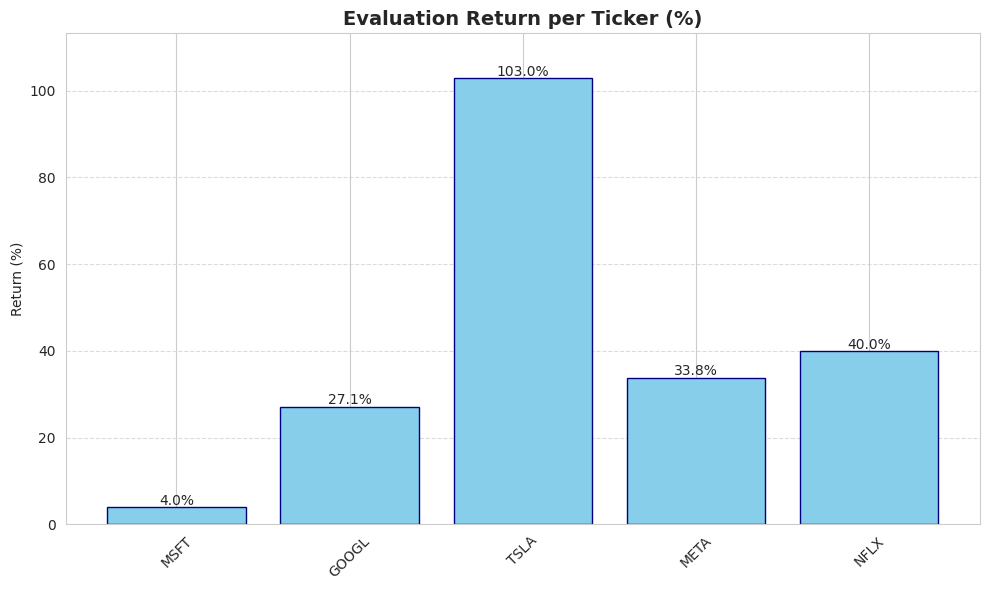

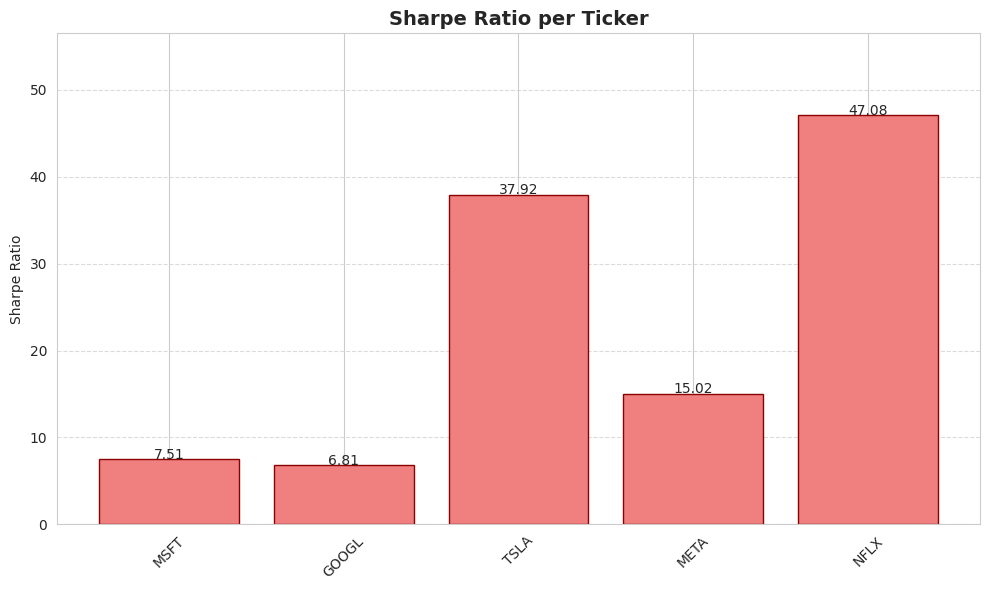


Average Evaluation Return: 41.60%
Average Sharpe Ratio: 22.87


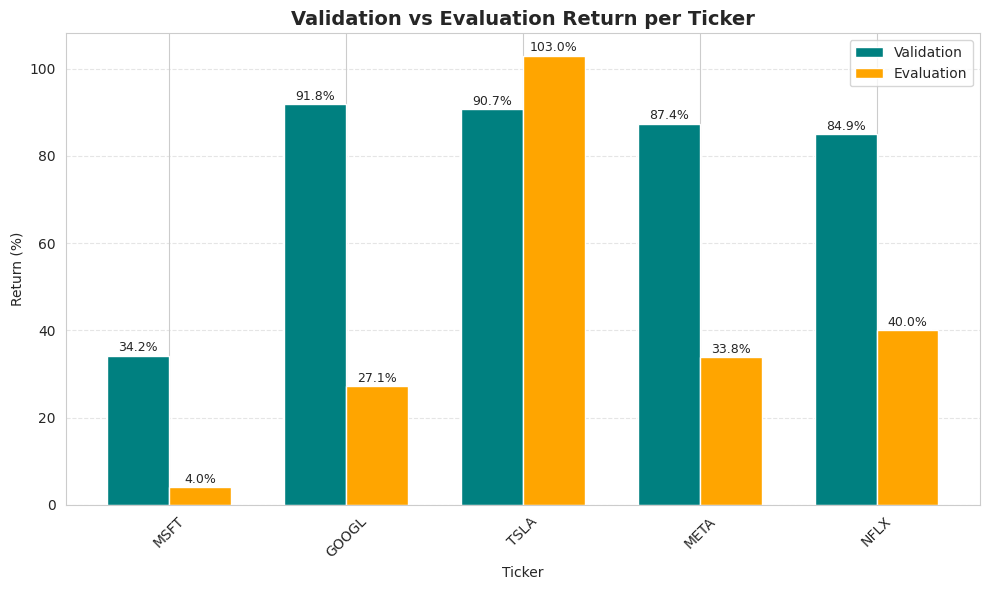

{'MSFT': {'total_ret': np.float64(0.3419983404693647),
  'sharpe': np.float64(0.9933325879015286),
  'max_dd': np.float64(-0.15979839098427273),
  'bh_ret': 0.5858017547607424},
 'GOOGL': {'total_ret': np.float64(0.9183438579383867),
  'sharpe': np.float64(1.5170634256214248),
  'max_dd': np.float64(-0.21684317962668448),
  'bh_ret': 0.9717284446716308},
 'TSLA': {'total_ret': np.float64(0.9072832562423718),
  'sharpe': np.float64(0.9494487002999263),
  'max_dd': np.float64(-0.4569647097326095),
  'bh_ret': 0.9345819915771485},
 'META': {'total_ret': np.float64(0.8737517848983818),
  'sharpe': np.float64(1.4944894017333863),
  'max_dd': np.float64(-0.18232723155349975),
  'bh_ret': 2.3172103759765625},
 'NFLX': {'total_ret': np.float64(0.8493787564056445),
  'sharpe': np.float64(1.262621345739448),
  'max_dd': np.float64(-0.25295944060111986),
  'bh_ret': 1.4553269439697267}}

In [ ]:
validate_ppo()

In [ ]:
# ──────────────────────────────────────────────────────────────
# Cell 11 – Evaluation (with Matplotlib plots)
# ──────────────────────────────────────────────────────────────
def evaluate_ppo(model_path='ppo_trading_multi_stock.pth', n_episodes=10):
    safe = [StandardScaler,
            np.float64,np.float32,np.int64,np.int32,np.bool_,np.int8,np.int16]
    with torch.serialization.safe_globals(safe):
        ckpt = torch.load(model_path, map_location=DEVICE, weights_only=False)
    scalers = ckpt['scalers']
    tickers = ckpt['tickers']
    md = MarketData()
    data_store = []
    for t in tickers:
        _, test_df = md.get_train_test_split(t)
        feat = md.compute_features(test_df)
        data_store.append((t, feat))
    sample = data_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample.size + 2  # +2 for cash_norm, shares_norm
    policy = PolicyNet(state_dim, len(tickers)).to(DEVICE)
    policy.load_state_dict(ckpt['policy_state_dict'])
    policy.eval()

    results = {}
    sharpes = {}
    portfolio_vals_list = {}  # for sharpe

    for i, (t, feat) in enumerate(data_store):
        rets = []
        all_port_vals = []
        for _ in range(n_episodes):
            env = TradingEnv(feat, scalers[t], ticker_idx=i)
            s = env.reset_episode()
            port_vals = [env.initial_cash]
            while not env.done:
                obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
                ti = torch.tensor([s['ticker_idx']]).long().to(DEVICE)
                with torch.no_grad():
                    a = policy(obs, ti).argmax(dim=1).item()
                s, _, done, _ = env.step(a)
                curr_val = env.cash + env.shares * float(env.df.iloc[env.current_step]['Close'])
                port_vals.append(curr_val)
            final = port_vals[-1]
            rets.append(final / env.initial_cash - 1.0)
            all_port_vals.append(port_vals)
        results[t] = np.mean(rets)
        # Sharpe per episode average
        daily_rets = [np.mean(np.diff(pv) / np.array(pv[:-1])) for pv in all_port_vals if len(pv) > 1]
        mean_ret = np.mean(daily_rets)
        std_ret = np.std(daily_rets)
        sharpe = mean_ret / std_ret * np.sqrt(252) if std_ret > 0 else 0
        sharpes[t] = sharpe

    # ─── Plot 1: Evaluation Return per Ticker ───
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(results.keys(), [v*100 for v in results.values()], color='skyblue', edgecolor='navy')
    plt.title('Evaluation Return per Ticker (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Return (%)')
    plt.ylim(0, max(results.values())*110)
    for bar in bars1:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.5, f'{h:.1f}%', ha='center', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ─── Plot 2: Sharpe Ratio per Ticker ───
    plt.figure(figsize=(10, 6))
    bars2 = plt.bar(sharpes.keys(), sharpes.values(), color='lightcoral', edgecolor='darkred')
    plt.title('Sharpe Ratio per Ticker', fontsize=14, fontweight='bold')
    plt.ylabel('Sharpe Ratio')
    plt.ylim(0, max(sharpes.values()) * 1.2)
    for bar in bars2:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.05, f'{h:.2f}', ha='center', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    avg_ret = np.mean(list(results.values())) * 100
    avg_sharpe = np.mean(list(sharpes.values()))
    print(f"\nAverage Evaluation Return: {avg_ret:.2f}%")
    print(f"Average Sharpe Ratio: {avg_sharpe:.2f}")

    return results, sharpes

/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1270889352.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
/tmp/ipython-input-1270889352.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(subset=['Close','Volume']).fillna(method='bfill').fillna(method='ffill'

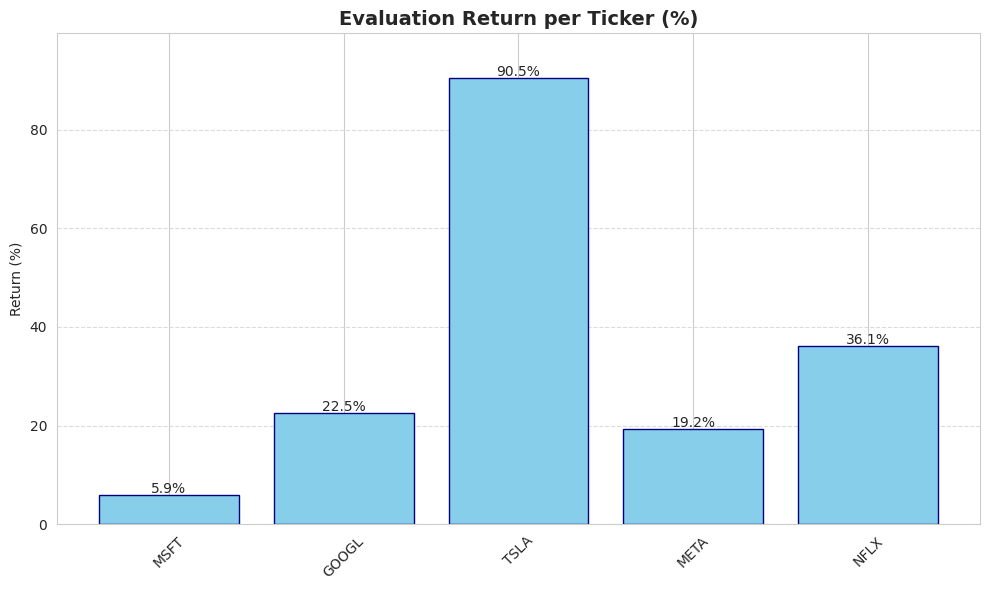

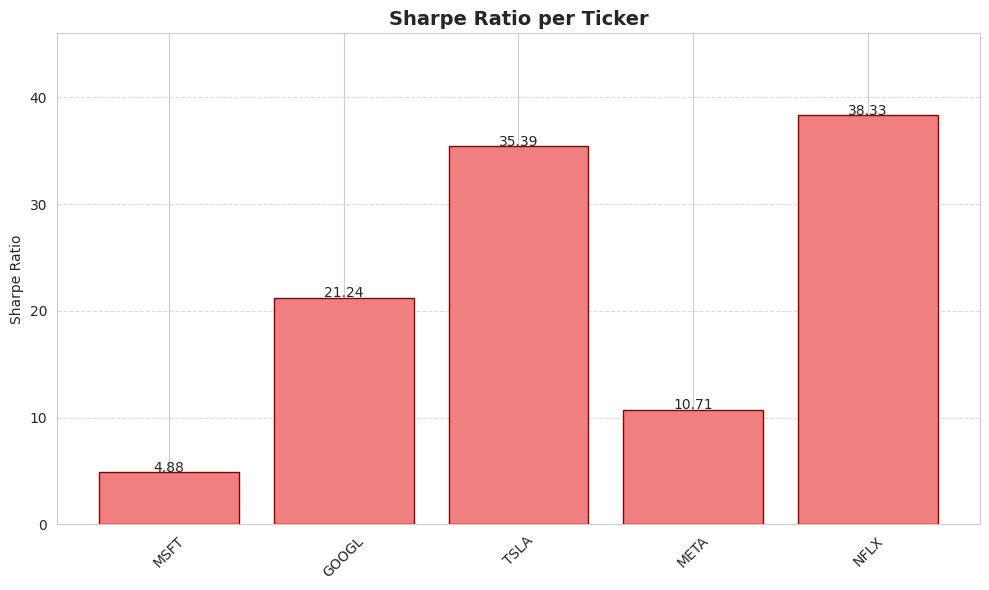


Average Evaluation Return: 34.84%
Average Sharpe Ratio: 22.11


({'MSFT': np.float64(0.0590721321679706),
  'GOOGL': np.float64(0.22493826230636665),
  'TSLA': np.float64(0.9046360602565013),
  'META': np.float64(0.19249300417602747),
  'NFLX': np.float64(0.3610053755239889)},
 {'MSFT': np.float64(4.882933684928491),
  'GOOGL': np.float64(21.23942399462239),
  'TSLA': np.float64(35.39134661322025),
  'META': np.float64(10.70545681534576),
  'NFLX': np.float64(38.32509317157177)})

In [ ]:
evaluate_ppo(n_episodes=10)